<a href="https://colab.research.google.com/github/Nickil21/ml-planetary-albedo/blob/main/Task_1_Machine_Learning_Model_for_the_Planetary_Albedo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1: Predicting the Lunar Albedo based on Chemical Composition
---

*author: [Nickil Maveli](https://nickil21.github.io/)*

In this task, we are asked to identify relationship between albedo and composition by dividing the data into two equal halves (left and right). We are required to train our models on the left half and predict the right. The task can be viewed as a standard regression one which aims to predict the brightness of each pixel. Finally, we create a framework for combining outputs of constituent models using the stacking framework.

In [1]:
# Load essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, ElasticNet, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

from xgboost.sklearn import XGBRegressor
from lightgbm.sklearn import LGBMRegressor

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

plt.style.use('fivethirtyeight') # For better style
%matplotlib inline

Read the datasets provided at the [github link](https://github.com/ML4SCI/ML4SCI_GSoC/tree/main/Messenger/Moon)

In [2]:
BASE_URL = "https://raw.githubusercontent.com/ML4SCI/ML4SCI_GSoC/main/Messenger/Moon/"

# Load albedo map
albedo_map = pd.read_csv(BASE_URL + "Albedo_Map.csv", header=None)
NUM_ROWS = albedo_map.shape[0]
NUM_COLS = albedo_map.shape[1]
CENTER_HALF = NUM_COLS // 2

# Load iron map
lpfe_map = pd.read_csv(BASE_URL + "LPFe_Map.csv", header=None)

# Load potassium map
lpk_map = pd.read_csv(BASE_URL + "LPK_Map.csv", header=None)

# Load thorium map
lpth_map = pd.read_csv(BASE_URL + "LPTh_Map.csv", header=None)

# Load titanium map
lpti_map = pd.read_csv(BASE_URL + "LPTi_Map.csv", header=None)

Plotting the albedo map to confirm if we are reading the file correctly as a sanity check.

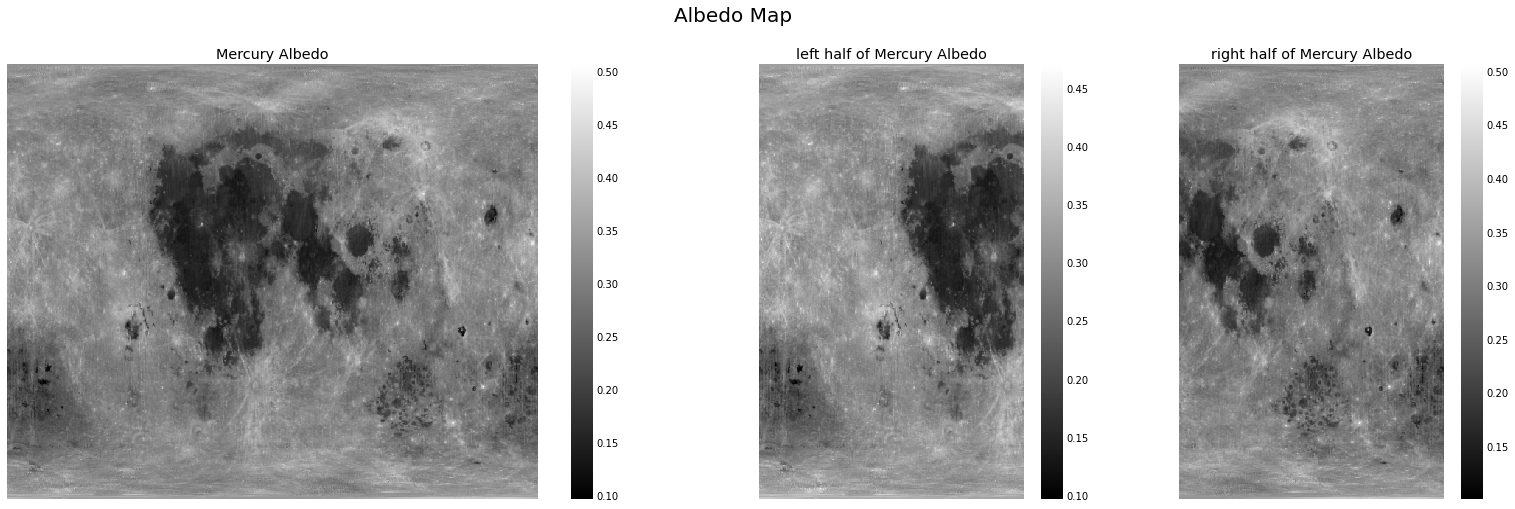

In [3]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(24, 8), gridspec_kw={'width_ratios': [2,1,1]})

sns.heatmap(albedo_map, cmap="gray", xticklabels=False, yticklabels=False, ax=ax1)
ax1.set_title("Mercury Albedo")

sns.heatmap(albedo_map.iloc[:, :CENTER_HALF], cmap="gray", xticklabels=False, yticklabels=False, ax=ax2)
ax2.set_title("left half of Mercury Albedo")

sns.heatmap(albedo_map.iloc[:, CENTER_HALF:], cmap="gray", xticklabels=False, yticklabels=False, ax=ax3)
ax3.set_title("right half of Mercury Albedo")

plt.suptitle("Albedo Map", fontsize=20)
plt.show()

Plotting the chemical composition maps.

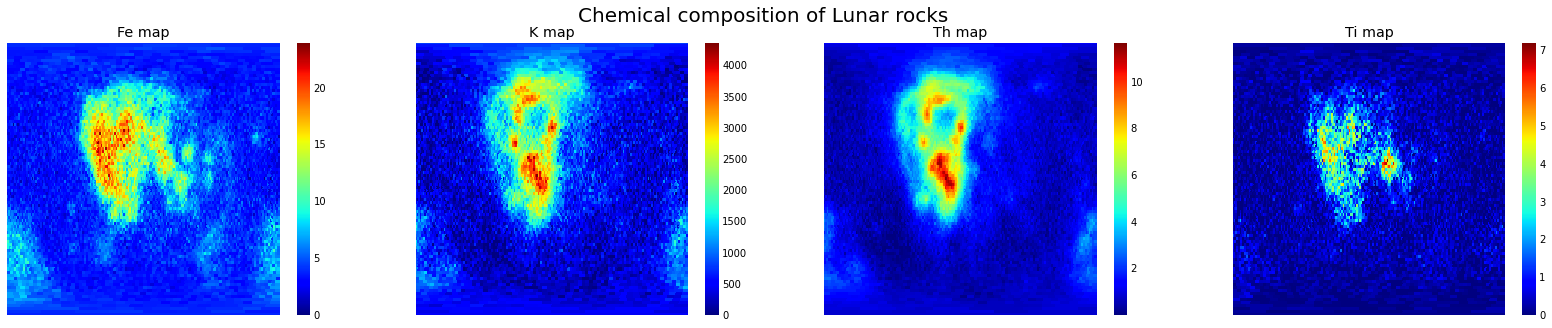

In [4]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=1, ncols=4, figsize=(25, 5))

sns.heatmap(lpfe_map, cmap="jet", xticklabels=False, yticklabels=False, ax=ax1)
ax1.set_title("Fe map")

sns.heatmap(lpk_map, cmap="jet", xticklabels=False, yticklabels=False, ax=ax2)
ax2.set_title("K map")

sns.heatmap(lpth_map, cmap="jet", xticklabels=False, yticklabels=False, ax=ax3)
ax3.set_title("Th map")

sns.heatmap(lpti_map, cmap="jet", xticklabels=False, yticklabels=False, ax=ax4)
ax4.set_title("Ti map")

plt.suptitle("Chemical composition of Lunar rocks", fontsize=20)
plt.show()

A bit of feature engineering.

In [5]:
def add_interaction_features(data):
    data['potassium_iron_interaction'] = data['potassium'] * data['iron']
    data['potassium_thorium_interaction'] = data['potassium'] * data['thorium']
    data['potassium_titanium_interaction'] = data['potassium'] * data['titanium']
    data['iron_thorium_interaction'] = data['iron'] * data['thorium']
    data['iron_titanium_interaction'] = data['iron'] * data['titanium']
    data['thorium_titanium_interaction'] = data['thorium'] * data['titanium']
    return data

We divide the albedo and it's corresponding chemical composition maps into two equal portions. The left-half becomes the training data and the right-half becomes the test data.

In [6]:
df_left_half = pd.DataFrame()

df_left_half['albedo']    = albedo_map.iloc[:, :CENTER_HALF].values.reshape(-1, 1).flatten()
df_left_half['iron']      = lpfe_map.iloc[:, :CENTER_HALF].values.reshape(-1, 1).flatten()
df_left_half['potassium'] = lpk_map.iloc[:, :CENTER_HALF].values.reshape(-1, 1).flatten()
df_left_half['thorium']   = lpth_map.iloc[:, :CENTER_HALF].values.reshape(-1, 1).flatten()
df_left_half['titanium']  = lpti_map.iloc[:, :CENTER_HALF].values.reshape(-1, 1).flatten()

df_right_half = pd.DataFrame()

df_right_half['albedo']    = albedo_map.iloc[:, CENTER_HALF:].values.reshape(-1, 1).flatten()
df_right_half['iron']      = lpfe_map.iloc[:, CENTER_HALF:].values.reshape(-1, 1).flatten()
df_right_half['potassium'] = lpk_map.iloc[:, CENTER_HALF:].values.reshape(-1, 1).flatten()
df_right_half['thorium']   = lpth_map.iloc[:, CENTER_HALF:].values.reshape(-1, 1).flatten()
df_right_half['titanium']  = lpti_map.iloc[:, CENTER_HALF:].values.reshape(-1, 1).flatten()

Let us perform a pair-wise scatter plot.

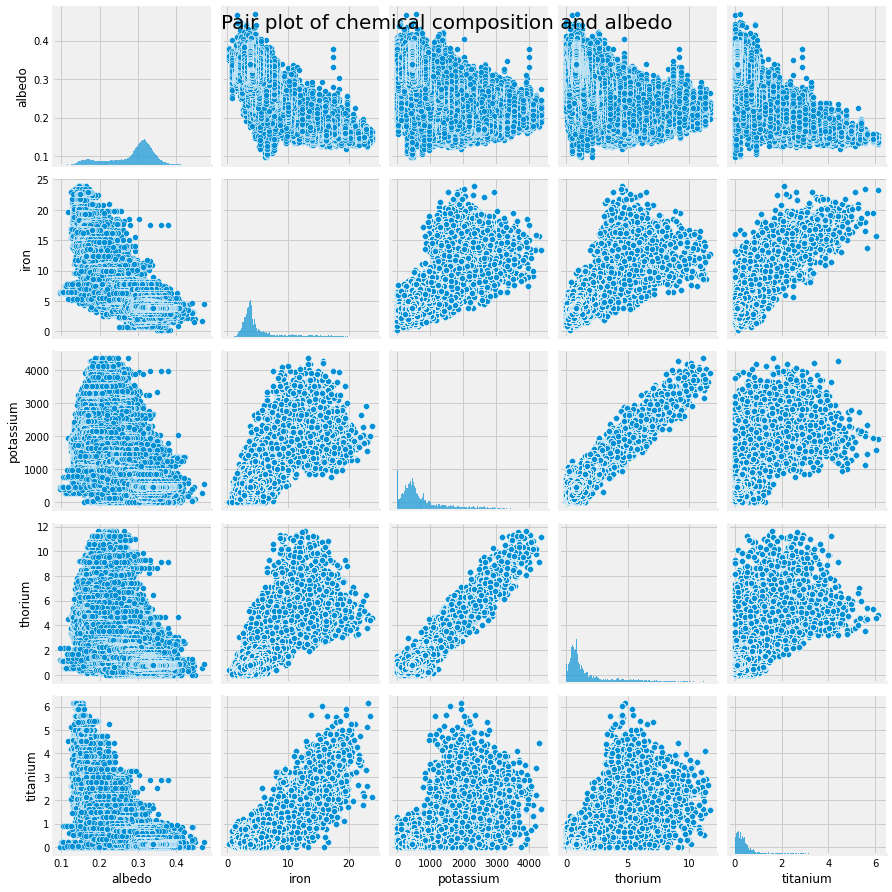

In [7]:
cols = df_left_half.columns.tolist()
sns.pairplot(df_left_half[cols])
plt.tight_layout()
plt.suptitle("Pair plot of chemical composition and albedo", fontsize=20);

As we can infer from the above plot, there are a couple of outliers (although few) for all the chemical compositions, due to the skeweness in the data. Since the spread is not that significant, we can choose to keep it in the modeling process.

Let us look for some correlations in the dataset.

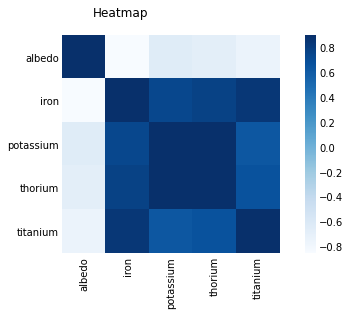

In [8]:
corr = df_left_half.corr()
plt.subplots(figsize=(8, 4))
sns.heatmap(corr, vmax=0.9, cmap="Blues", square=True)
plt.suptitle("Heatmap")
plt.show()

As shown above, potassium and thorium have the maximum correlation. Followed by iron and titanium which has slightly lesser correlation.

In [9]:
df_left_half = add_interaction_features(df_left_half)
df_right_half = add_interaction_features(df_right_half)

In [10]:
features = ['iron', 'potassium', 'thorium', 'titanium', 'potassium_iron_interaction', 'potassium_thorium_interaction',
            'potassium_titanium_interaction', 'iron_thorium_interaction', 'iron_titanium_interaction', 'thorium_titanium_interaction']

In [11]:
X_train = df_left_half[features]
y_train = df_left_half['albedo'].values
X_test = df_right_half[features]
y_test = df_right_half['albedo'].values

In [12]:
#Validation function
n_folds = 2 # 5

def mse_cv(model):
    kf = KFold(n_folds, shuffle=False).get_n_splits(X_train.values)
    mse = -cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv=kf)
    return mse

We experiment with the following set of models:

1. Linear Regression
2. Lasso Regression
3. Elastic Net Regression
4. Gradient Boosting Regression
5. XGBoost
6. LightGBM
7. Neural Network (MLP)

In [13]:
linear_reg = make_pipeline(StandardScaler(), LinearRegression())

lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))

ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state=5)

The procedure, for the training part, may be described as follows:

1. Split the total training set into two disjoint sets, namely train and holdout.

2. Train several base models on the first part (train)

3. Test these base models on the second part (holdout)

4. Use the predictions (from 3) (called out-of-folds predictions) as the inputs, and the correct responses (target variable) as the outputs to train a higher level learner called meta-model.

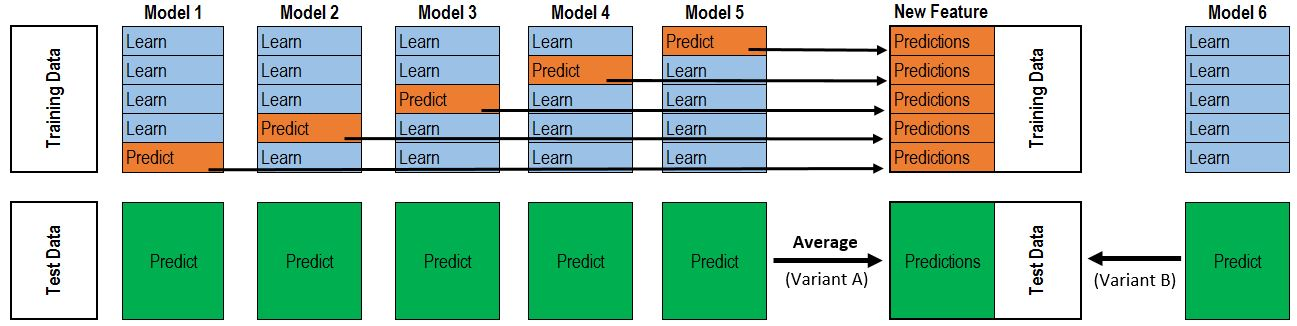

Image taken from [here](https://www.kaggle.com/getting-started/18153#103381).

In [14]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=2):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=False)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [15]:
stacked_averaged_models = StackingAveragedModels(base_models=(linear_reg, ENet, GBoost),
                                                 meta_model=lasso)

score = mse_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.0011 (0.0003)


In [16]:
stacked_averaged_models.fit(X_train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(X_train.values)
stacked_pred = stacked_averaged_models.predict(X_test.values)

In [17]:
print('MAE:', mean_absolute_error(y_test, stacked_train_pred))
print('MSE:', mean_squared_error(y_test, stacked_train_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, stacked_train_pred)))

MAE: 0.05952097669416593
MSE: 0.006005889976332378
RMSE: 0.07749767723185243


In [18]:
model_xgb = XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                        learning_rate=0.05, max_depth=3, 
                        min_child_weight=1.7817, n_estimators=2200,
                        reg_alpha=0.4640, reg_lambda=0.8571,
                        subsample=0.5213, silent=1,
                        random_state=7, nthread=-1)

In [19]:
model_xgb.fit(X_train, y_train)
xgb_train_pred = model_xgb.predict(X_train)
xgb_pred = model_xgb.predict(X_test)

In [20]:
print('MAE:', mean_absolute_error(y_test, xgb_train_pred))
print('MSE:', mean_squared_error(y_test, xgb_train_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, xgb_train_pred)))

MAE: 0.059391524068225496
MSE: 0.006123035257343534
RMSE: 0.07824982592532417


In [21]:
model_lgb = LGBMRegressor(objective='regression', num_leaves=5,
                        learning_rate=0.05, n_estimators=720,
                        max_bin=55, bagging_fraction=0.8,
                        bagging_freq=5, feature_fraction=0.2319,
                        feature_fraction_seed=9, bagging_seed=9,
                        min_data_in_leaf=6, min_sum_hessian_in_leaf=11)

In [22]:
model_lgb.fit(X_train, y_train)
lgb_train_pred = model_lgb.predict(X_train)
lgb_pred = model_lgb.predict(X_test.values)

In [23]:
print('MAE:', mean_absolute_error(y_test, lgb_train_pred))
print('MSE:', mean_squared_error(y_test, lgb_train_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, lgb_train_pred)))

MAE: 0.059377925459583335
MSE: 0.006120688434174505
RMSE: 0.07823482877960752


In [24]:
# define wider model
def wider_model():
    # create model
    model = Sequential()
    model.add(Dense(32, input_dim=10, kernel_initializer='normal', activation='relu'))
    model.add(Dense(16, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [25]:
np.random.seed(42)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=wider_model, epochs=3, batch_size=32, verbose=1)))
nn_model = Pipeline(estimators)

score = mse_cv(nn_model)
print("NN models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Epoch 1/3
2025/2025 [==============================] - 3s 1ms/step - loss: 0.0065
Epoch 2/3
2025/2025 [==============================] - 2s 1ms/step - loss: 8.7640e-04
Epoch 3/3
2025/2025 [==============================] - 2s 755us/step
Epoch 1/3
2025/2025 [==============================] - 3s 1ms/step - loss: 0.0070
Epoch 2/3
2025/2025 [==============================] - 2s 1ms/step - loss: 5.0916e-04
Epoch 3/3
2025/2025 [==============================] - 2s 782us/step
NN models score: 0.0012 (0.0005)


In [26]:
nn_model.fit(X_train.values, y_train)
nn_train_pred = nn_model.predict(X_train.values)
nn_pred = nn_model.predict(X_test.values)

Epoch 1/3
4050/4050 [==============================] - 5s 1ms/step - loss: 0.0041
Epoch 2/3
4050/4050 [==============================] - 4s 1ms/step - loss: 7.3956e-04
Epoch 3/3
4050/4050 [==============================] - 3s 766us/step


In [27]:
print('MAE:', mean_absolute_error(y_test, nn_train_pred))
print('MSE:', mean_squared_error(y_test, nn_train_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, nn_train_pred)))

MAE: 0.0601903411819025
MSE: 0.006311102421261535
RMSE: 0.07944244722603612


In [28]:
y_pred = (stacked_pred + xgb_pred + lgb_pred + nn_pred) / 4

In [29]:
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

MAE: 0.023106635893180384
MSE: 0.0009107811937793944
RMSE: 0.030179151641147806


MSE of **0.00091** looks decent.

In [30]:
RIGHT_PREDICTED = y_pred.reshape(NUM_ROWS, CENTER_HALF)
RIGHT_ACTUAL = albedo_map.iloc[:, CENTER_HALF:]

We now compare the albedo prediction to the albedo map.

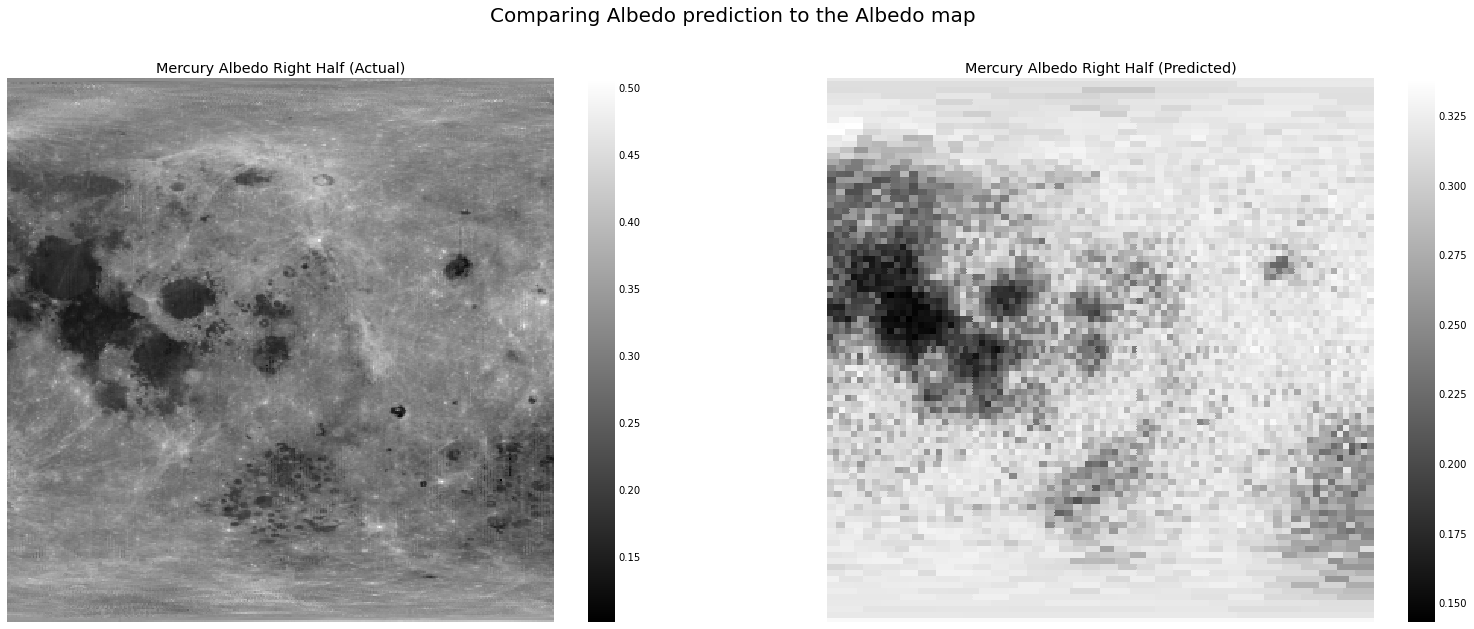

In [31]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(24, 10))

g1 = sns.heatmap(RIGHT_ACTUAL, cmap="gray", xticklabels=False, yticklabels=False, ax=ax1)
g1.set_title("Mercury Albedo Right Half (Actual)")

g2 = sns.heatmap(RIGHT_PREDICTED, cmap="gray", xticklabels=False, yticklabels=False, ax=ax2)
g2.set_title("Mercury Albedo Right Half (Predicted)")

plt.suptitle("Comparing Albedo prediction to the Albedo map", fontsize=20)
plt.show();

Overall, the (stacked) model performed exceedingly well and was able to re-create a considerable portion of craters for the albedo map corresponding to the right hand side. Although, the pixel quality can be better constructed. We think this can be achieved by integrating geographical features, such as lat/long co-ordinates, surface level information, and so on.

Residuals, in the context of regression models, are the difference between the observed value of the target variable (y) and the predicted value (ŷ), i.e. the error of the prediction. The residuals plot shows the difference between residuals on the vertical axis and the dependent variable on the horizontal axis, allowing you to detect regions within the target that may be susceptible to more or less error.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


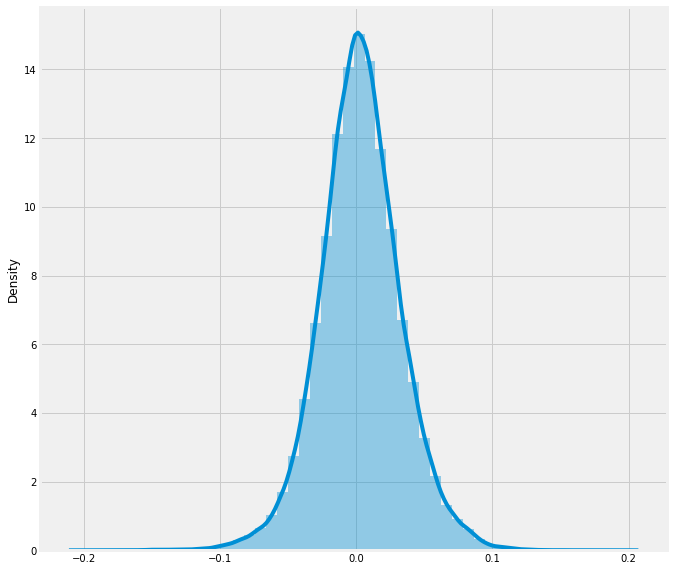

In [35]:
residuals = (RIGHT_ACTUAL - RIGHT_PREDICTED)

fig, ax = plt.subplots(figsize=(10, 10))
sns.distplot(residuals.values, kde=True);

As we can infer from the above image, the residues are roughly in the range ± 0.10.

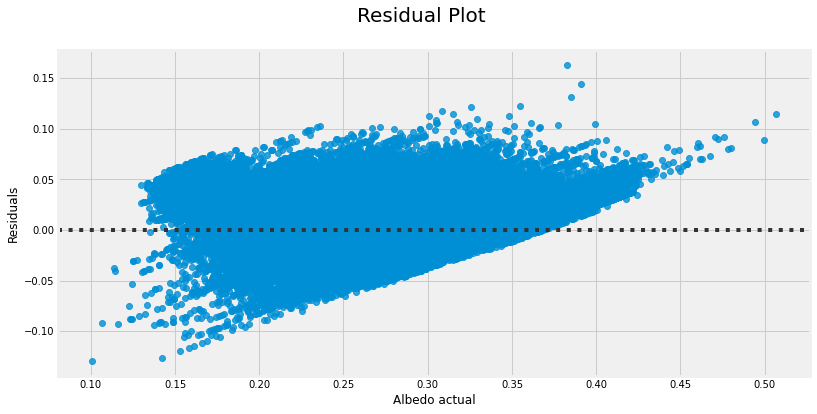

In [36]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.residplot(x=RIGHT_ACTUAL.values.ravel(), y=residuals.values.ravel())
ax.set_xlabel("Albedo actual")
ax.set_ylabel("Residuals")
plt.suptitle("Residual Plot", fontsize=20)
plt.show();